In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import random
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Conv2D,SeparableConv2D,Dense,Input,Flatten,MaxPooling2D,AveragePooling2D,Activation
from keras.layers import Concatenate,Add,Multiply,Lambda
from keras.layers import BatchNormalization,Dropout
from keras.models import Model,Sequential
from matplotlib.image import imread
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from shufflenetv2 import ShuffleNetV2
from keras import optimizers
import keras.applications
from keras.utils import multi_gpu_model
from keras import backend as K
from keras import regularizers
import scipy
from pet_data import load_data,data_augment,split_annotations
from drawing import *
from importlib  import reload

In [4]:
input_H = 224
input_W = 224
input_C = 3
input_shape = (input_H, input_W, input_C)
output_num = 37
root='/home/cai/dataset/pets'

## Load Raw Data

In [5]:
#read_class_names(annot):
import pet_data
reload(pet_data)
from pet_data import split_annotations
annot = root +'/annotations'
file = open(os.path.join(annot,'class_names.txt'))
lines = open(os.path.join(annot,'class_names.txt')).readlines()
class_names = [name[:-1] for name in lines]
num_classes = len(class_names)
split_annotations(root,'list.txt',task='classification')
print(class_names)
print('classes num',num_classes)

[]
['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
classes num 37


In [20]:
#Load 50% training data and 30% testing data
(x_train,y_train),(x_test,y_test) = load_data(0.1,1,root=root)
print('done')

.........................done
done


## Visualize data

total training examples  551
total testing examples  1838
x_train shape (551, 224, 224, 3)
x_test shape (1838, 224, 224, 3)
y_train shape (551, 37)
y_test shape (1838, 37)
abyssinian


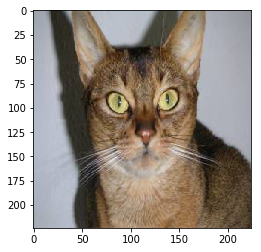

american_bulldog


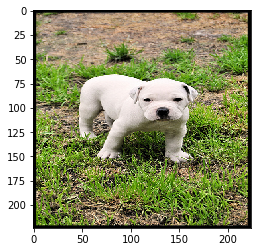

american_pit_bull_terrier


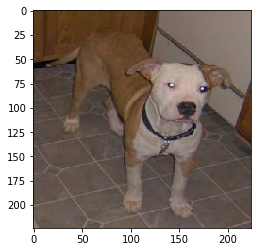

basset_hound


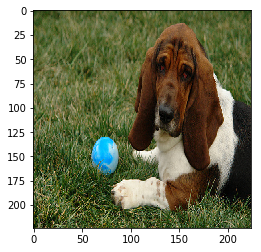

beagle


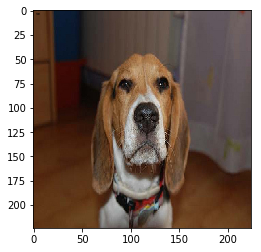

bengal


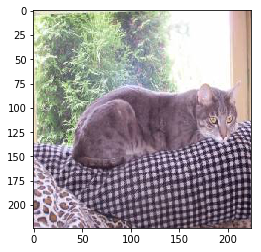

birman


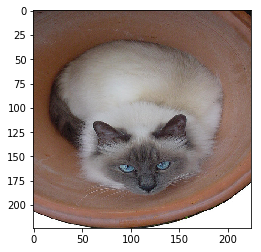

bombay


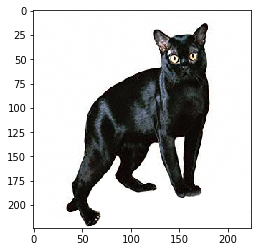

boxer


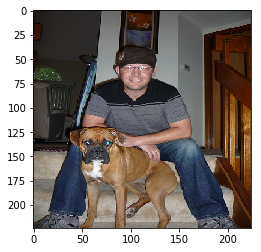

british_shorthair


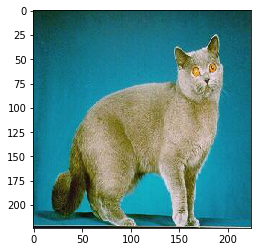

chihuahua


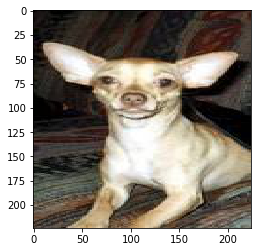

egyptian_mau


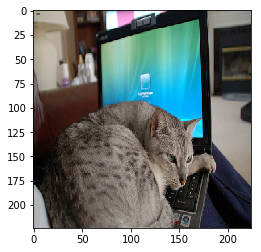

english_cocker_spaniel


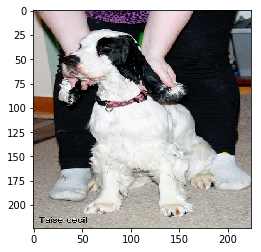

english_setter


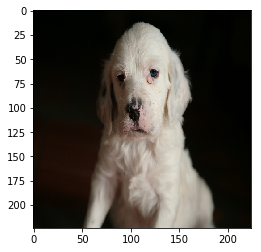

In [22]:
print('total training examples ',x_train.shape[0])
print('total testing examples ',x_test.shape[0])
print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)
idx = []
class_pos = 0
for k,y in enumerate(y_train):
    if class_pos == num_classes:
        break
    if y[class_pos] == 1:
        idx.append(k)
        class_pos += 1
show_data(x_train,y_train,idx,class_names)

In [10]:
def build_simple_densenet():
    'for training set size = 4 can achieve training accuracy 1 under [200epochs 2batch_size  mse sgd] '
    'sigmoid: loss '
    x = Sequential() 
    x.add(Conv2D(3,(3,3),padding='same',strides=(2,2),data_format='channels_last',input_shape=(input_H,input_W,input_C)))
    x.add(Activation('tanh'))
    x.add(Flatten())
    x.add(Dense(3000,activation= 'tanh'))
    x.add(Dense(1000,activation= 'tanh'))
    x.add(Dense(500,activation= 'tanh'))
    x.add(Dense(40,activation= 'tanh'))
    x.add(Dense(2,activation= 'softmax'))
    return 'simple_densenet',x

def build_simple_convnet():
    x = Sequential()
    activation = 'relu'
    #l2_reg = kernel_regularizer=regularizers.l2(0.01)
    l2_reg = regularizers.l2(5e-4)
    x.add(Conv2D(32,(3,3),padding='same',strides=(1,1),data_format='channels_last',input_shape=(input_H,input_W,input_C)))
    x.add(Conv2D(64,(3,3),padding='same',strides=(1,1),kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(MaxPooling2D(strides=2,data_format='channels_last'))
    x.add(Activation(activation))
    x.add(Conv2D(128,  3,padding='same',strides=1,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(Conv2D(128,  3,padding='same',strides=1,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(MaxPooling2D(strides=2,data_format='channels_last'))
    x.add(Activation(activation))
    x.add(Conv2D(256,  3,padding='same',strides=2,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(Conv2D(256,  3,padding='same',strides=1,kernel_regularizer=l2_reg,data_format='channels_last'))
    x.add(MaxPooling2D(strides=2,data_format='channels_last'))
    x.add(Activation(activation))
    x.add(Flatten())
    x.add(Dropout(0.5))
    x.add(Dense(1024,activation=activation))
    x.add(Dropout(0.5))
    x.add(Dense(2,activation=activation))
    x.add(Activation('softmax'))
    return 'simple_convnet',x

def build_mimic_mobilenet():
    inputs = Input(shape=(input_H,input_W,input_C))
    x = BasicConv(inputs,32,3,2)
    x = BasicSepConv(x,32,3,1)
    x = BasicConv(x,64,1,1)
    x = BasicSepConv(x,64,3,2)
    x = BasicConv(x,128,1)
    x = BasicSepConv(x,128,3)
    x = BasicConv(x,128,1)
    x = BasicSepConv(x,256,3)
    x = BasicConv(x,256,1)
    x = BasicSepConv(x,256,3,2)
    x = BasicConv(x,512,1)
    for i in range(0,5):
        x = BasicSepConv(x,512,3)
        x = BasicConv(x,512,1)
    x = BasicSepConv(x,512,3,2)
    x = BasicConv(x,1024,1)
    x = BasicSepConv(x,1024,3,2)
    x = BasicConv(x,1024,1)
    x = AveragePooling2D(3)(x)
    x = Flatten()(x)
    x = Dense(2,activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    return 'mimic_mobilenet',model

def build_simple_rfbnet():
    inputs = Input(shape=(input_H,input_W,input_C))
    x = BasicConv(inputs,32,3,2)
    x = BasicRFB(x,64,2)
    x = BasicRFB(x,256)
    for  i in range(0,3):
        x = BasicRFB_a(x,256,2)
    x = BasicFC(x,output_num)
    model = Model(inputs=inputs, outputs=x)
    return  'simple_rfbnet',model
def build_mobilenet_v2():
    inputs = Input(shape=(input_H,input_W,input_C))
    base_model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, depth_multiplier=1, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
    for layer in base_model.layers[:-36]:
        layer.trainable = False
    x = base_model.get_layer('out_relu').output
    x = AveragePooling2D(strides = 7)(x)
    x = Flatten()(x)
    x = Dense(2000)(x)
    x = Dropout(0.35)(x)
    x = Dense(output_num, activation= 'softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return 'mobilenet_v2',model

def build_shufflenet_v2():
    inputs = Input(shape=(input_H,input_W,input_C))
    base_model = ShuffleNetV2()
    out = base_model.output
    out = Dense(output_num, activation= 'softmax')(out)
    model = Model(inputs=base_model.input, outputs=out)  
    return 'shufflenet_v2',model
#multi_gpu_model(model, gpus=1, cpu_merge=True, cpu_relocation=False)


In [17]:
def fit_generator(model,x_train,y_train,batch_size,epochs):
    (train_flow,val_flow) = data_augment(x_train,y_train,batch_size)
    history = model.fit_generator(train_flow,steps_per_epoch=len(x_train)/batch_size,validation_data=val_flow,validation_steps=300,epochs=epochs_per_stage,shuffle = True)
    return history
def plot_training(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Set training params

In [23]:
#reload(detection_nets)
source_name ="out_relu"
build_model = build_mobilenet_v2
show_summary = True
#Train
phase = 'training' #training or testing
epochs_per_stage = 8
stages = 8
epoch_decay = 6
batch_size = 4
verbose = True
use_data_augment = True
plot = False
#Environment
#clear_session = True
#Learning params
lr=1e-4
decay=1e-6
momentum=0.9
validation_split = 0.25
load_weights = True
save_weights = True
check_point = 14
log_file = "log_classification"
log = True

## Build model

In [24]:
model_name,model=build_model()
model.compile(optimizer=optimizers.SGD(lr=lr,decay=decay,momentum=momentum),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
if show_summary:
    model.summary()
print('model:',model_name,'has been built')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## Training or testing

In [25]:
#file.close()
save_file = 'saved_weights' + '/'  + model_name + '_' + "%d" + ".h5"
if log:
    file = open(log_file,'a+')
if load_weights:
    model.load_weights(save_file %check_point)
    print("weights loaded from check point",check_point)
    if phase == 'training':
        check_point += 1
if phase == 'training':
    info =('model name' ,model_name , \
           '\nstart fitting.. ' , '\nstages:' , stages, ' epochs_per_stage:',epochs_per_stage, ' plot_history:' ,plot,\
           '\ntrainset size:', len(y_train), ' validation_split:',validation_split,\
           '\nlearning rate:' ,lr  ,' decay:' ,decay , ' momentum:' ,momentum ,  \
           '\ninitial checkpoint:', check_point ,  \
           '\nload weight:' ,load_weights)
    if verbose:
        print(*info)
    if log:
        print(*info,file=file)
    for i in range(1,1+stages):
        epochs = epochs_per_stage - epoch_decay * i // stages
        if verbose:
            print("Stage ",i,"/",stages)
            print("Epoch num",epochs)
        if log:
            print("Stage ",i,"/",stages,file=file)
            print("Epoch num",epochs,file=file)
        if not use_data_augment:
            history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, verbose = verbose, validation_split = validation_split)
        else:
            history = fit_generator(model,x_train,y_train,batch_size,epochs)
        #fit_generator(model,x_train,y_train)
        if save_weights:
            if verbose:
                print("save at",save_file % check_point)
            model.save_weights(save_file % check_point)
            check_point += 1 
        #ac = evaluate(model,x_test,y_test)
        if plot:
            plot_history(history)
elif phase =='testing':
    if verbose:
        print('start evaluating')
    loss = model.evaluate(x=x_test,y=y_test)
    ac = evaluate(model,x_test,y_test)
    if verbose:
        print('loss',round(result,5))
        print('ac',ac)
    if log:
        print('loss',round(result,5),file=file)
        print('ac',ac,file=file)

weights loaded from check point 14
model name mobilenet_v2 
start fitting..  
stages: 8  epochs_per_stage: 8  plot_history: False 
trainset size: 551  validation_split: 0.25 
learning rate: 0.0001  decay: 1e-06  momentum: 0.9 
initial checkpoint: 15 
load weight: True
Stage  1 / 8
Epoch num 8
Epoch 1/8
138/137 [==============================] - 10s 75ms/step - loss: 0.0257 - acc: 0.9928
Epoch 2/8
138/137 [==============================] - 6s 45ms/step - loss: 0.0294 - acc: 0.9891
Epoch 3/8
138/137 [==============================] - 5s 40ms/step - loss: 0.0343 - acc: 0.9909
Epoch 4/8
138/137 [==============================] - 6s 44ms/step - loss: 0.0374 - acc: 0.9873
Epoch 5/8
138/137 [==============================] - 6s 46ms/step - loss: 0.0226 - acc: 0.9928
Epoch 6/8
138/137 [==============================] - 6s 45ms/step - loss: 0.0362 - acc: 0.9873
Epoch 7/8
138/137 [==============================] - 6s 42ms/step - loss: 0.0215 - acc: 0.9928
Epoch 8/8
138/137 [=====================

In [18]:
show_false_pics(model, x_test, y_test)

KeyboardInterrupt: 